**Helpful Links: Where the Data Lives**

Open Academic Society: [Project Page](https://www.openacademic.ai/oag/)

Microsoft Research: [MS Academic Graph](https://www.microsoft.com/en-us/research/project/microsoft-academic-graph/)

In [2]:
import pandas as pd

In [25]:
model_df = pd.read_json('data/mag_papers_0/mag_subset20K.txt', lines=True)

model_df.shape

(20000, 19)

In [26]:
model_df.columns

Index(['abstract', 'authors', 'doc_type', 'doi', 'fos', 'id', 'issue',
       'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'publisher',
       'references', 'title', 'url', 'venue', 'volume', 'year'],
      dtype='object')

In [27]:
# filter out non-English articles
# keep abstract, authors, fos, keywords, year, title
model_df = model_df[model_df.lang == 'en'].drop_duplicates(subset = 'title', 
                                                           keep = 'first').drop(['doc_type', 
                                                                                                   'doi', 'id', 
                                                                                                   'issue', 'lang', 
                                                                                                   'n_citation', 
                                                                                                   'page_end', 
                                                                                                   'page_start', 
                                                                                                   'publisher', 
                                                                                                   'references',
                                                                                                   'url', 'venue', 
                                                                                                   'volume'], axis=1)

model_df.shape

(10399, 6)

In [28]:
model_df.head(2)

,abstract,authors,fos,keywords,title,year
0,A system and method for maskless direct write ...,NaN,"[Electronic engineering, Computer hardware, En...",NaN,System and Method for Maskless Direct Write Li...,2015
1,NaN,[{'name': 'Ahmed M. Alluwaimi'}],"[Biology, Virology, Immunology, Microbiology]","[paratuberculosis, of, subspecies, proceedings...",The dilemma of the Mycobacterium avium subspec...,2016


# (1) raw data > algorithm w/ XKCD comic

## Content Based Recommendation using cosine similarity

How to go about building a recommender system? 

Let's start simple with a few fields. We'll calculate the cosine similarity between two items, then rank the results to choose a "most similar" paper for each input.

We can already see that this dataset will need some wrangling. Lists and dictionaries are good for data storage, but not [tidy](http://vita.had.co.nz/papers/tidy-data.html) or well-suited for machine learning without some unpacking.

In [41]:
unique_fos = sorted(list({ feature
                          for paper_row in model_df.fos.fillna('0')
                          for feature in paper_row }))

unique_year = sorted(model_df['year'].astype('str').unique())

len(unique_fos + unique_year)

7760

In [47]:
model_df.shape[0] - pd.isnull(model_df['fos']).sum()

8666

In [42]:
len(unique_fos)

7604

In [56]:
import random
[unique_fos[i] for i in sorted(random.sample(range(len(unique_fos)), 15)) ]

['Call control',
 'Coupling constant',
 'Evapotranspiration',
 'Hash function',
 'IVMS',
 'Meditation',
 'Pareto analysis',
 'Second-generation wavelet transform',
 'Slip',
 'Spiral galaxy',
 'Subthreshold slope',
 'TCP Westwood',
 'Time of arrival',
 'de Sitter–Schwarzschild metric',
 'route']

In [12]:
def feature_array(x, unique_array):
    row_dict = {}
    for i in x.index:
        var_dict = {}
        
        for j in range(len(unique_array)):
            if type(x[i]) is list:
                if unique_array[j] in x[i]:
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
            else:    
                if unique_array[j] == str(x[i]):
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
        
        row_dict.update({i : var_dict})
    
    feature_df = pd.DataFrame.from_dict(row_dict, dtype='str').T
    
    return feature_df

In [13]:
%time year_features = feature_array(model_df['year'], unique_year)

CPU times: user 36.8 s, sys: 314 ms, total: 37.1 s
Wall time: 37.5 s


In [14]:
%time fos_features = feature_array(model_df['fos'], unique_fos)

from sys import getsizeof
print('Size of fos feature array: ', getsizeof(fos_features))

CPU times: user 27min 46s, sys: 11.6 s, total: 27min 58s
Wall time: 28min 26s
Size of fos feature array:  2530632380


In [15]:
year_features.shape[1] + fos_features.shape[1]

7760

In [16]:
# now looking at 10399 x  7760 array for our feature space

%time first_features = fos_features.join(year_features).T

first_size = getsizeof(first_features)

print('Size of first feature array: ', first_size)

CPU times: user 14.4 s, sys: 1.43 s, total: 15.8 s
Wall time: 16.3 s
Size of first feature array:  2583077234


Let's see how our current features perform at giving us a good recommendation. We'll define a "good" recommendation as a paper that looks similar to the input.

We will start with a simple example of building a recommender with just a few fields, building sparse arrays of available features to calculate for the cosine similary between papers. We will see if reasonably similar papers can be found in a timely manner.

In [21]:
first_features.shape

(7760, 10399)

In [22]:
first_features.head()

,0,1,2,5,7,8,9,10,11,12,...,19985,19986,19987,19988,19993,19994,19995,19997,19998,19999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0-10 V lighting control,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/N expansion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10G-PON,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14-3-3 protein,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
from scipy.spatial.distance import cosine

def item_collab_filter(features_df):
    item_similarities = pd.DataFrame(index = features_df.columns, columns = features_df.columns)
    
    for i in features_df.columns:
        for j in features_df.columns:
            item_similarities.loc[i][j] = 1 - cosine(features_df[i], features_df[j])
    
    return item_similarities

In [24]:
%time first_items = item_collab_filter(first_features.loc[:, 0:1000])

CPU times: user 7min 53s, sys: 2.32 s, total: 7min 55s
Wall time: 8min


We need to get a better idea of how these features will translate to us getting a good recommendation. Do we have enough observations to move forward? Let's plot a heatmap to see if we have any papers that are similar to each other.

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [26]:
%matplotlib inline

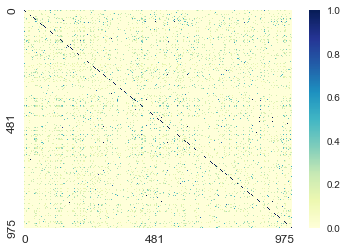

In [27]:
sns.set()
ax = sns.heatmap(first_items.fillna(0), 
                 vmin=0, vmax=1, 
                 cmap="YlGnBu", 
                 xticklabels=250, yticklabels=250)
ax.tick_params(labelsize=12)

In [28]:
def paper_recommender(paper_index, items_df):
    print('Based on the paper: \nindex = ', paper_index)
    print(model_df.iloc[paper_index])
    top_results = items_df.loc[paper_index].sort_values(ascending=False).head(4)
    print('\nTop three results: ') 
    order = 1
    for i in top_results.index.tolist()[-3:]:
        print(order,'. Paper index = ', i)
        print('Similarity score: ', top_results[i])
        print(model_df.iloc[i], '\n')
        if order < 5: order += 1

In [29]:
paper_recommender(2, first_items)

Based on the paper: 
index =  2
abstract                                                  NaN
authors     [{'name': 'Jovana P. Lekovich', 'org': 'Weill ...
fos                                                       NaN
keywords                                                  NaN
title       Should endometriosis be an indication for intr...
year                                                     2015
Name: 2, dtype: object

Top three results: 
1 . Paper index =  2
Similarity score:  1.0
abstract                                                  NaN
authors     [{'name': 'Jovana P. Lekovich', 'org': 'Weill ...
fos                                                       NaN
keywords                                                  NaN
title       Should endometriosis be an indication for intr...
year                                                     2015
Name: 2, dtype: object 

2 . Paper index =  292
Similarity score:  1.0
abstract                                                  NaN
aut